In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# importing cv2 
import cv2
from google.colab.patches import cv2_imshow
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import tensorflow as tf
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

# Dataloading

In [ ]:
# prepare function
def process_image(path):
    img = cv2.imread(path)
    #img = cv2.resize(img, (150, 150), interpolation = cv2.INTER_CUBIC)
    img = img/255.0
    return img

In [ ]:
# preprocess images
train = []
train_noised = []
test = []
test_path = '/content/gdrive/MyDrive/EE610-Assignment-2/BSDS300/images/'
train_path = '/content/gdrive/MyDrive/EE610-Assignment-2/BSDS300/images/'

for f in tqdm(sorted(os.listdir(train_path + 'train/'))):
    train.append(process_image(train_path + 'train/' + f))

for f in tqdm(sorted(os.listdir(train_path + 'train_noised/'))):
    train_noised.append(process_image(train_path + 'train_noised/' + f))
   
for f in tqdm(sorted(os.listdir(test_path + 'test_noised/'))):
    test.append(process_image(test_path + 'test_noised/' + f))

100%|██████████| 100/100 [00:01<00:00, 83.19it/s]


In [ ]:
# store image names in list for later use
train_img = sorted(os.listdir(train_path + '/train'))
train_noised_img = sorted(os.listdir(train_path + '/train_noised'))
test_img = sorted(os.listdir(test_path + '/test_noised'))

In [ ]:
# convert list to numpy array
X_train = np.asarray(train_noised)
Y_train = np.asarray(train)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=42)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
Y_train[0].shape

(150, 150, 3)

#Modeling
- I am using **encoder-decoder** deep CNN model and training it end to end. The trained model obtained will be *image to image* mapping.
- **Encoder** has three convolutional blocks for extracting the features from an input image followed by batchnormalization, maxpooli and dropout.
- Decoder will

In [ ]:
def model():
    input_layer = Input(shape=(150, 150, 3))
    # Encoder
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_layer)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)

    # Decoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    output_layer = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)
    
    model = Model(inputs=[input_layer], outputs=[output_layer])
    
    optimizer = keras.optimizers.Adam(learning_rate=0.001) # changed from 0.001 for 2nd run
    model.compile(optimizer=optimizer , loss='mean_squared_error', metrics=['mse'])

    return model


model = model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 64)      51264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0     

In [ ]:
def scheduler(epoch, lr):
  # if epoch < 20:
  #   return lr
  # else:
  #   # # exponential decay
  #   # return lr * tf.math.exp(-0.1)

  # time-based decay
  decay = 0.001/500
  return lr * 1/(1 + decay*epoch)

#callback1 = EarlyStopping(monitor='loss', patience=10)
#callback2 = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
callback3 = keras.callbacks.LearningRateScheduler(scheduler, 1)

history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=1500, batch_size=16, verbose=1, callbacks=[callback3])

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-219aa753-cf27-b2ab-c9b9-573cc8c4bdec)


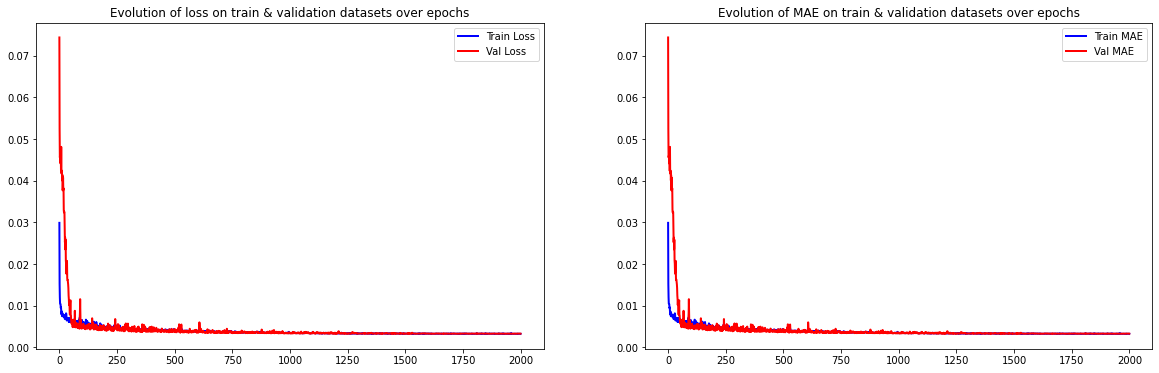

In [ ]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mse']
epoch_val_mae = history.history['val_mse']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()


In [ ]:
# predict/clean test images
Y_test = model.predict(X_test, batch_size=16)

In [ ]:
plt.figure(figsize=(15,25))
for i in range(len(Y_test)):
    cv2_imshow(X_test[i]*255.0)
    
    cv2_imshow(Y_test[i]*255.0)

plt.show()